In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import arviz as az
from gp_model import harmonic_sho_model
from hls import HarmonicLombScargle
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy.stats as ss
import seaborn as sns
from tqdm import tqdm

sns.set_theme(context='notebook', style='ticks', palette='colorblind')

In [87]:
search_result = lk.search_lightcurve('KIC 5111207')
lcs = [sr.download() for sr in tqdm(search_result)]

100%|██████████| 14/14 [00:00<00:00, 24.39it/s]


I am going to sigma-clip the fluxes of the light curve and add those points to the mask (the outliers make the GP fit particularly poor, I think).

In [88]:
lcs = [lc.remove_outliers() for lc in lcs]

In [89]:
times = [lc.time.value for lc in lcs]
fluxes = [lc.flux.value for lc in lcs]
flux_errs = [lc.flux_err.value for lc in lcs]
masks = [~f.mask for f in fluxes]

times = [t[m] for t, m in zip(times, masks)]
fluxes = [f[m] for f, m in zip(fluxes, masks)]
flux_errs = [f[m] for f, m in zip(flux_errs, masks)]

quarters = [float(i)*np.ones_like(t) for (i, t) in enumerate(times)]

times = np.concatenate(times).astype(np.float64)
fluxes = np.array(np.concatenate(fluxes).astype(np.float64))
flux_errs = np.array(np.concatenate(flux_errs).astype(np.float64))
quarters = np.concatenate(quarters)

uquarters, quarter_indices = np.unique(quarters, return_inverse=True)

In [90]:
hls = HarmonicLombScargle(times, fluxes, quarters, 3)

In [91]:
fgrid = hls.relative_frequency_grid(0.05)
logls = hls.logl_on_grid(fgrid)

  0%|          | 0/215 [00:00<?, ?it/s]/Users/wfarr/Code/harmonic-lomb-scargle/hls.py:57: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, (rss,), _, _ = np.linalg.lstsq(M, self.flux)
100%|██████████| 215/215 [00:02<00:00, 77.02it/s]


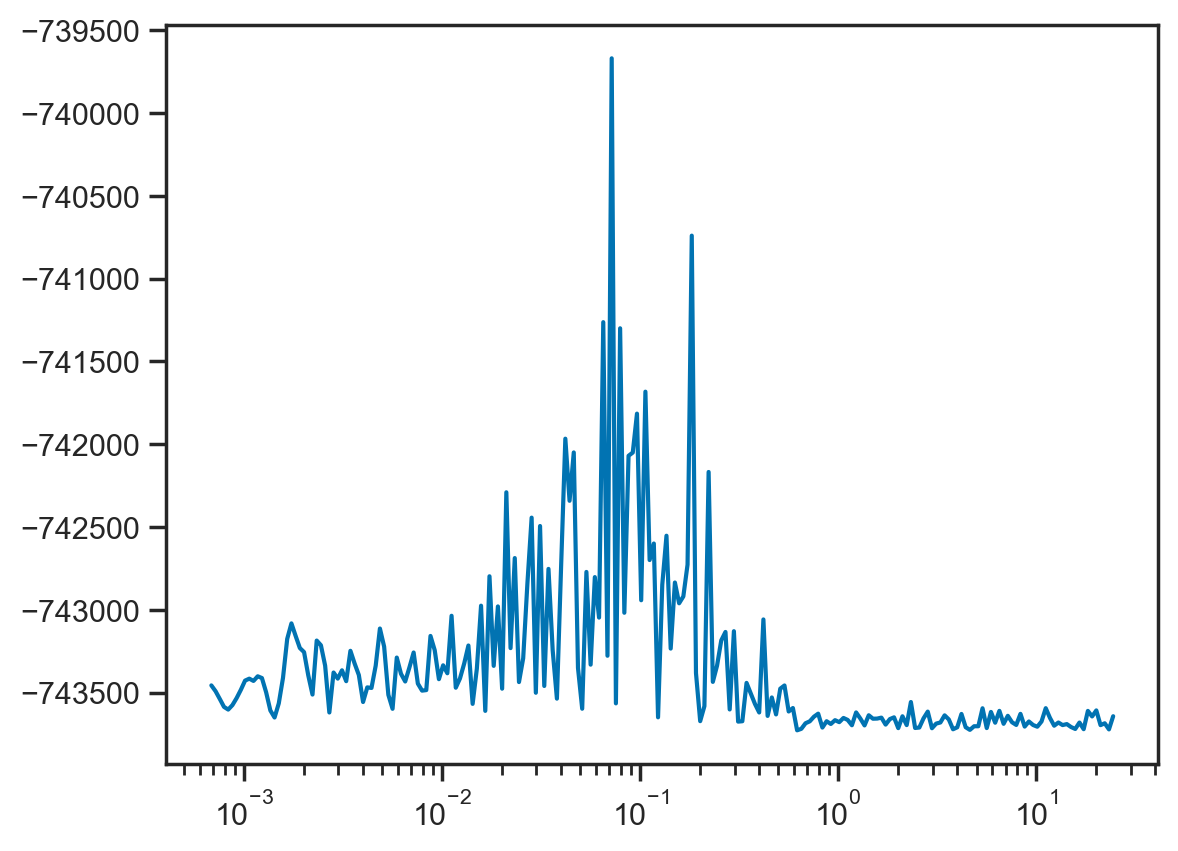

In [92]:
plt.plot(fgrid, logls)
plt.xscale('log')

100%|██████████| 215/215 [00:03<00:00, 69.28it/s]


(1, 100)

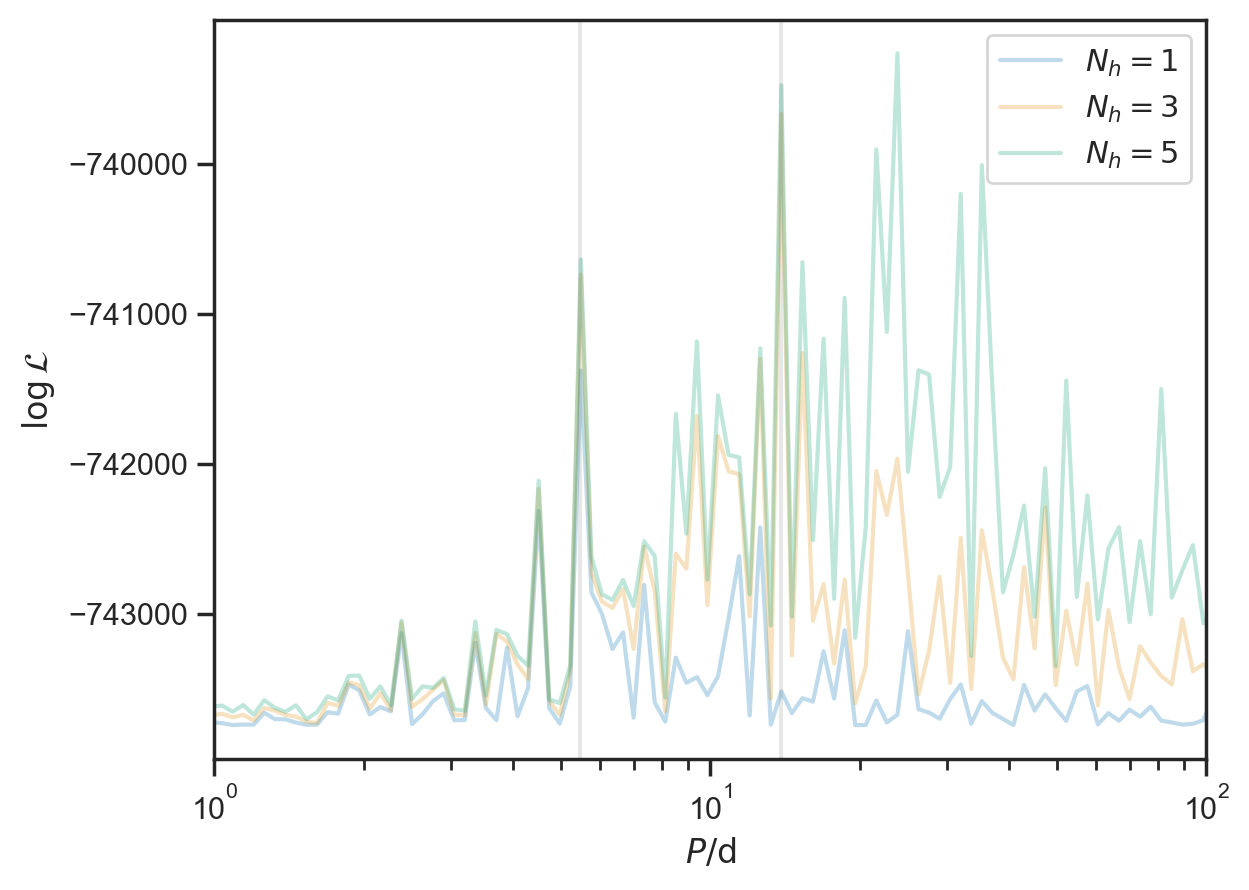

In [93]:
for nh in [1, 3, 5]:
    h = HarmonicLombScargle(times, fluxes, quarters, nh)
    fgrid = h.relative_frequency_grid(0.05)
    logls = h.logl_on_grid(fgrid)
    plt.plot(1/fgrid, logls, label=r'$N_h = {:d}$'.format(nh), alpha=0.25)
plt.xscale('log')
plt.xlabel(r'$P / \mathrm{d}$')
plt.ylabel(r'$\log \mathcal{L}$')
plt.legend()
plt.axvline(5.47, color='k', alpha=0.1)
plt.axvline(13.91, color='k', alpha=0.1)
plt.xlim(1, 100)

In [94]:
f_guess = fgrid[np.argmax(logls)]

fgrid_fine = hls.fine_frequency_grid(f_guess, 128)
logls_fine = hls.logl_on_grid(fgrid_fine)

100%|██████████| 128/128 [00:01<00:00, 74.38it/s]


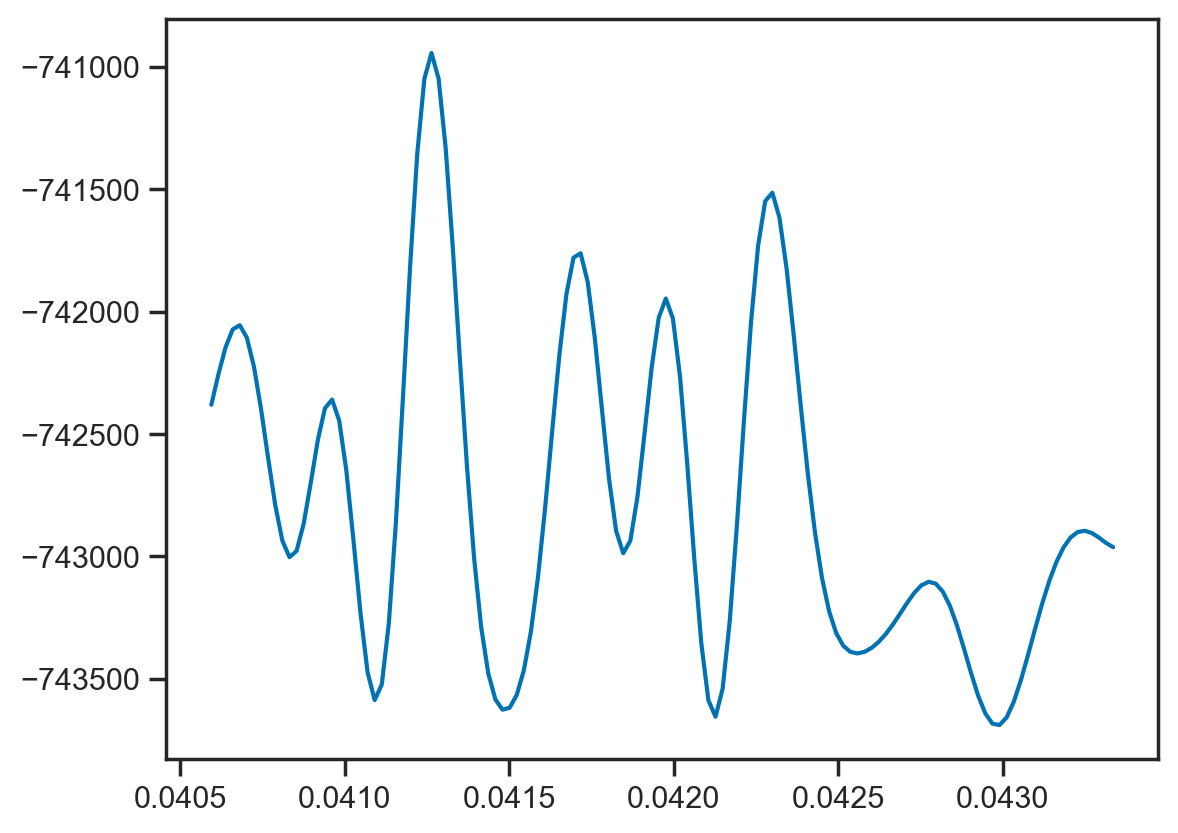

In [95]:
plt.plot(fgrid_fine, logls_fine)

In [96]:
f_best = hls.interpolated_best_frequency(fgrid_fine, logls_fine)
x_best = hls.best_fit_params(f_best)

print(f'f_best = {f_best}/day, or P = {1/f_best} days')

f_best = 0.04126392452069344/day, or P = 24.234243630862355 days


In [97]:
f_best_literature = 1/5.47

Text(0, 0.5, 'Residuals [e- / s]')

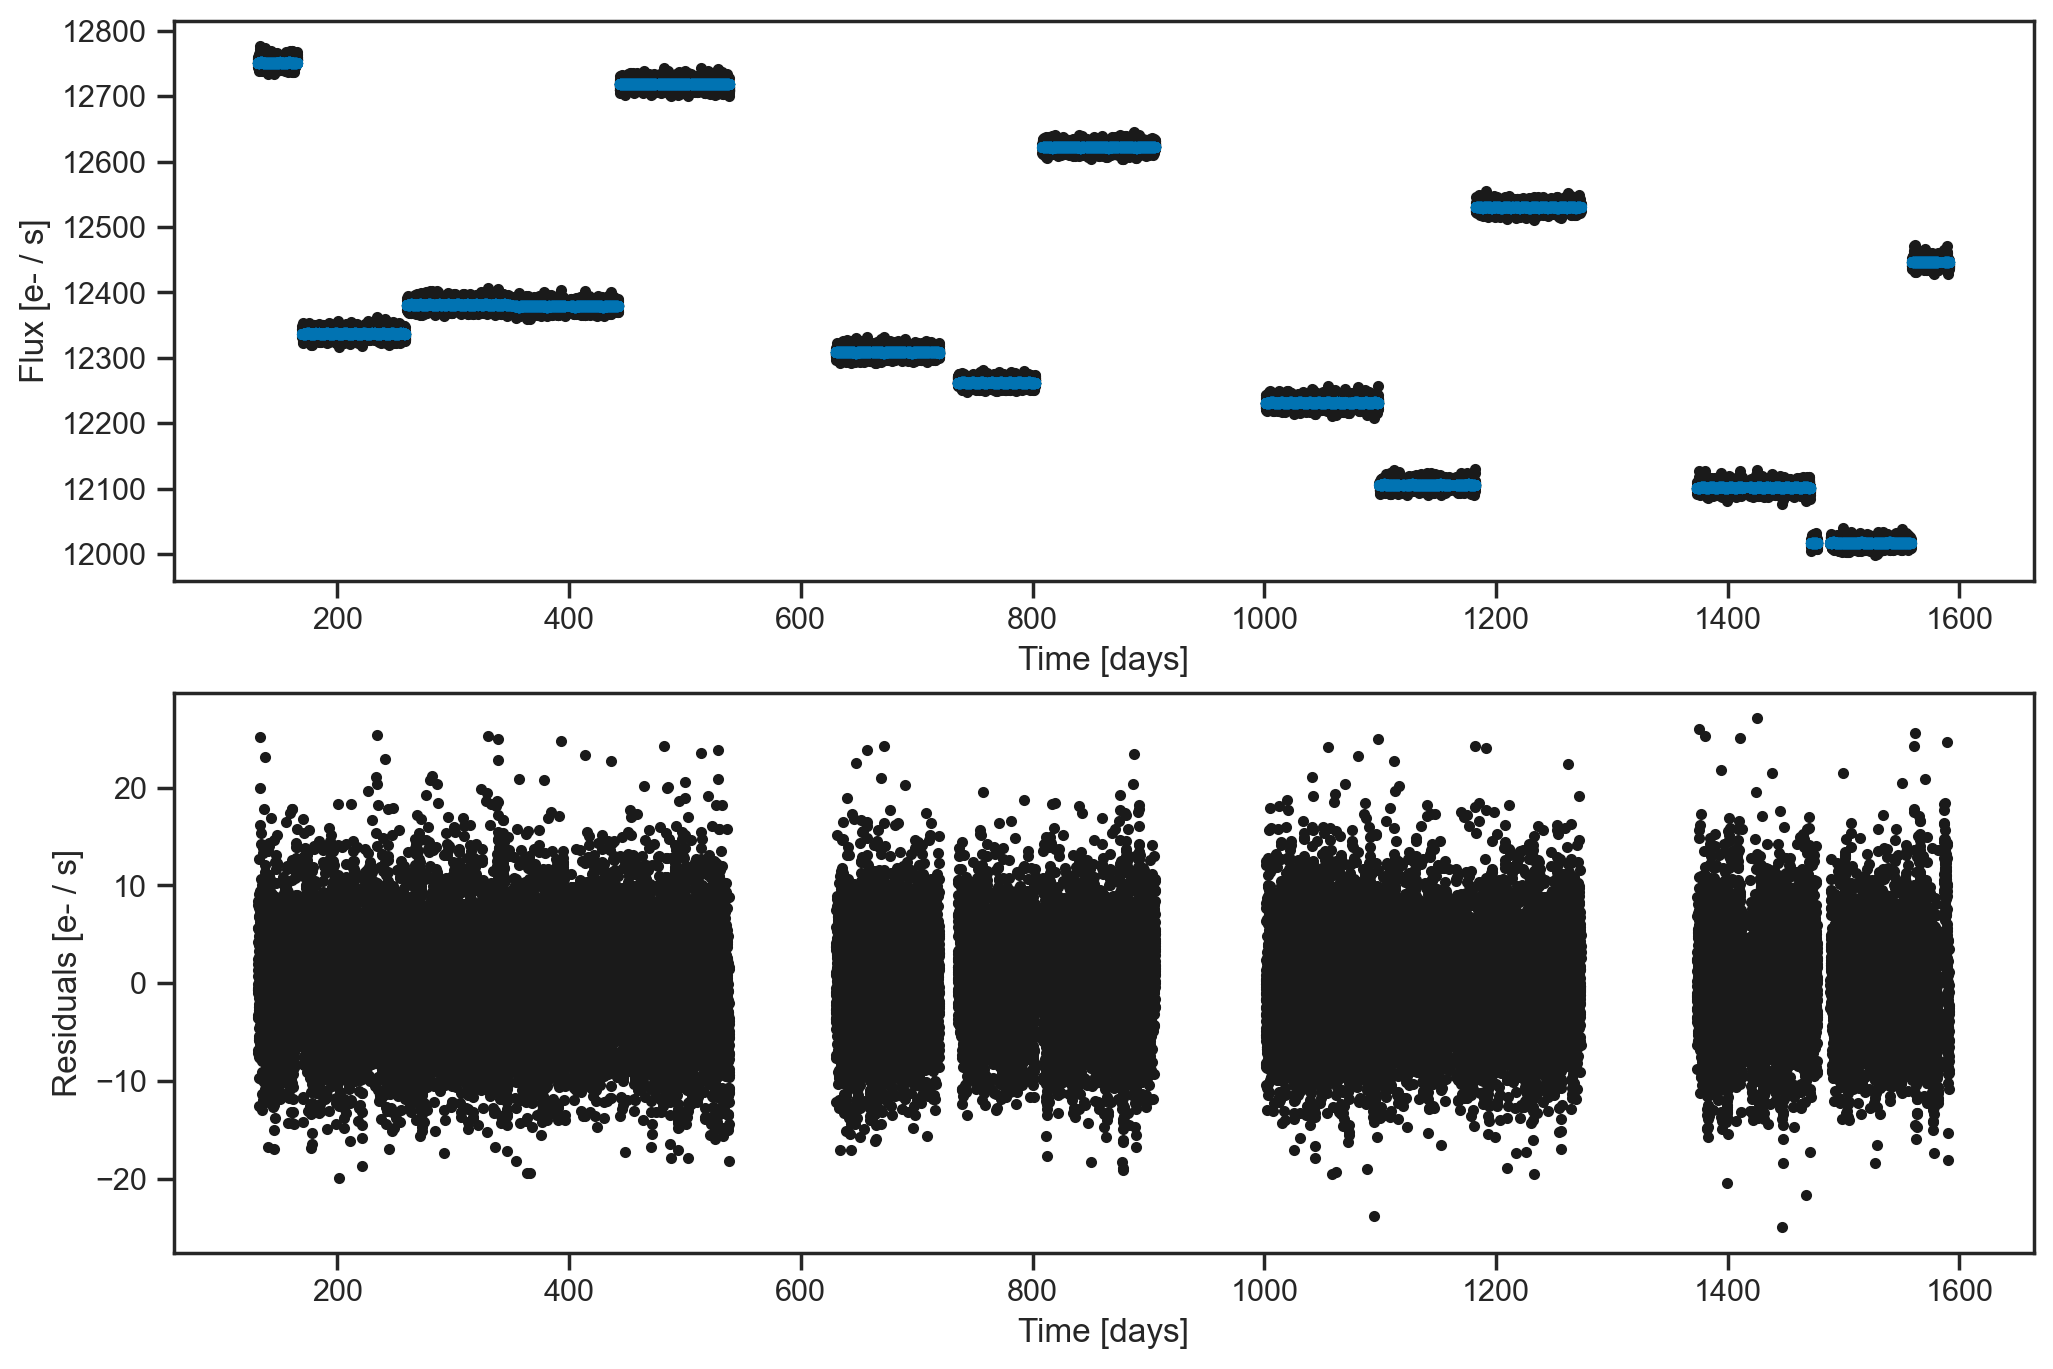

In [98]:
y = hls.predict_flux(f_best)

fig, subplots = plt.subplots(2, 1, figsize=(12, 8))

subplots[0].plot(times, fluxes, '.k')
subplots[0].plot(times, y, '.')
subplots[0].set_xlabel('Time [days]')
subplots[0].set_ylabel('Flux [e- / s]')

subplots[1].plot(times, fluxes - y, '.k')
subplots[1].set_xlabel('Time [days]')
subplots[1].set_ylabel('Residuals [e- / s]')

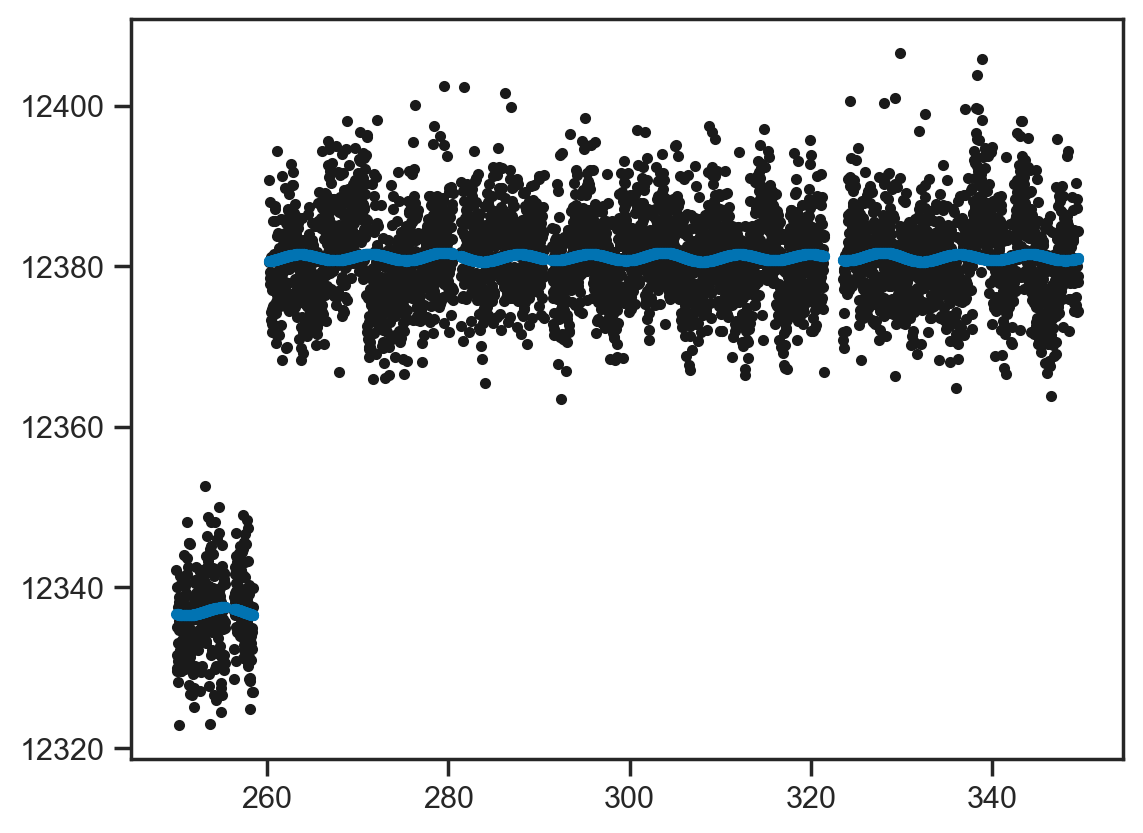

In [99]:
sel = np.abs(times - 300) < 50
plt.plot(times[sel], fluxes[sel], '.k')
plt.plot(times[sel], y[sel], '.')

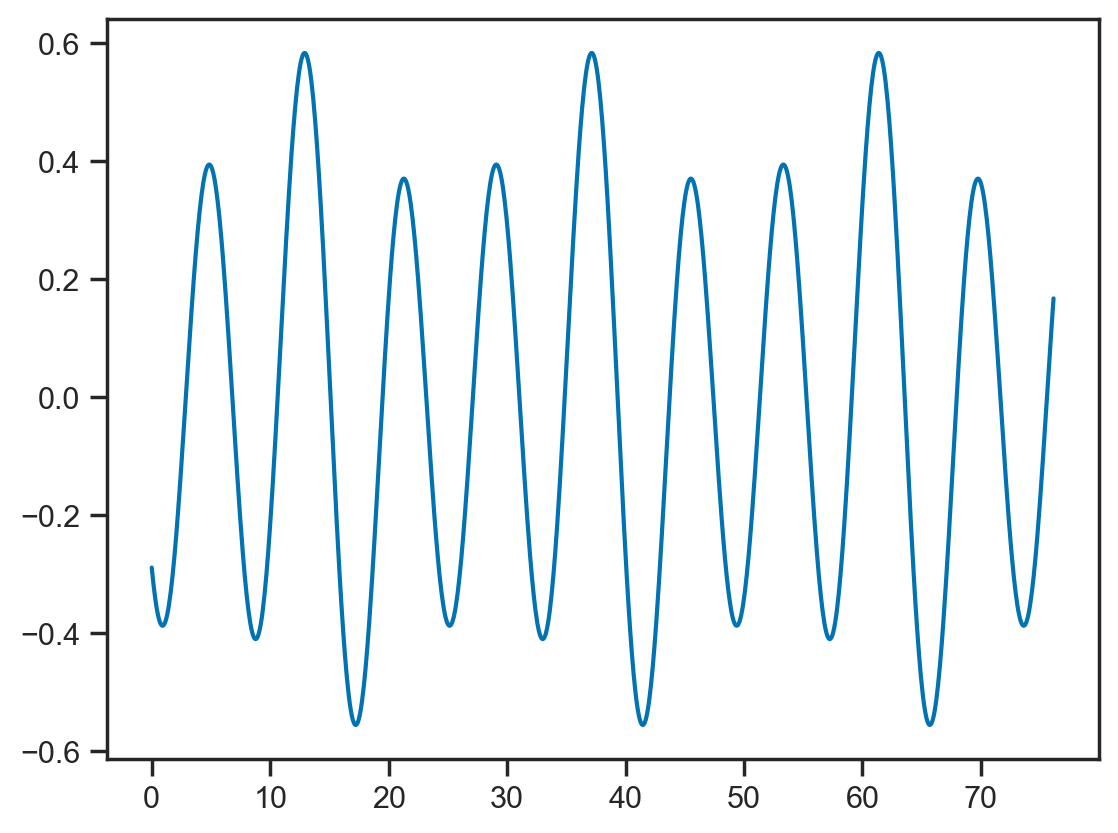

In [100]:
ts = np.linspace(0, np.pi*1/f_best, 1000)
plt.plot(ts, hls.periodic_lightcurve(ts, f_best, x_best))

Now let's try fitting some GP models.

In [101]:
n_in_quarters = np.bincount(quarter_indices)
quarter_means = np.bincount(quarter_indices, weights=fluxes) / n_in_quarters
quarter_vars = np.bincount(quarter_indices, weights=(fluxes - quarter_means[quarter_indices])**2) / n_in_quarters
quarter_stds = np.sqrt(quarter_vars)

total_var = np.sum(quarter_vars * n_in_quarters) / np.sum(n_in_quarters)
total_std = np.sqrt(total_var)

In [102]:
white_noise_variance = np.sum(flux_errs**2) / len(flux_errs)

In [103]:
dt = times[1]-times[0]
fny = 0.5 / dt
T = times[-1] - times[0]
df = 1/T

frequencies = np.arange(df, fny, df)

In [107]:
harmonics = [1] # Only the first harmonic for our first fit, we also provide a large uncertainty because we aren't really sure where the peak is.
thin_data = 1 # Set this to, say, 30 to thin the data by a factor of 30, improving runtime considerably.
model = harmonic_sho_model(times[::thin_data], fluxes[::thin_data], flux_errs[::thin_data], quarters[::thin_data], f_best_literature, harmonics, quarter_means, quarter_stds, total_std, psd_freq=frequencies, predict_times=times[::thin_data], f_frac_uncert=1)

In [108]:
trace = pm.sample(tune=1000, draws=1000, cores=4, chains=4, model=model, progressbar=True, jitter_max_retries=100, init='adapt_full')

Initializing NUTS using adapt_full...
/Users/wfarr/miniconda3/envs/harmonic-lomb-scargle/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:760: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mus_scaled, log_fs_scaled, log_Qs_scaled, log_sigma_scaled]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 187 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


It seems like there are always one or two chains that get stuck, so we will clean out the bad ones:

In [ ]:
trace.sample_stats.lp.mean(dim='draw')

<xarray.DataArray 'lp' (chain: 4)> Size: 32B
array([-155858.08392855, -155850.34742727, -155850.12691255,
       -155850.16102757])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3

It looks like chain 0 is "bad:"

In [113]:
trace = trace.sel(chain=[1,2,3])

array([[<Axes: title={'center': 'mus'}>, <Axes: title={'center': 'mus'}>],
       [<Axes: title={'center': 'fs'}>, <Axes: title={'center': 'fs'}>],
       [<Axes: title={'center': 'Qs'}>, <Axes: title={'center': 'Qs'}>],
       [<Axes: title={'center': 'sigmas'}>,
        <Axes: title={'center': 'sigmas'}>]], dtype=object)

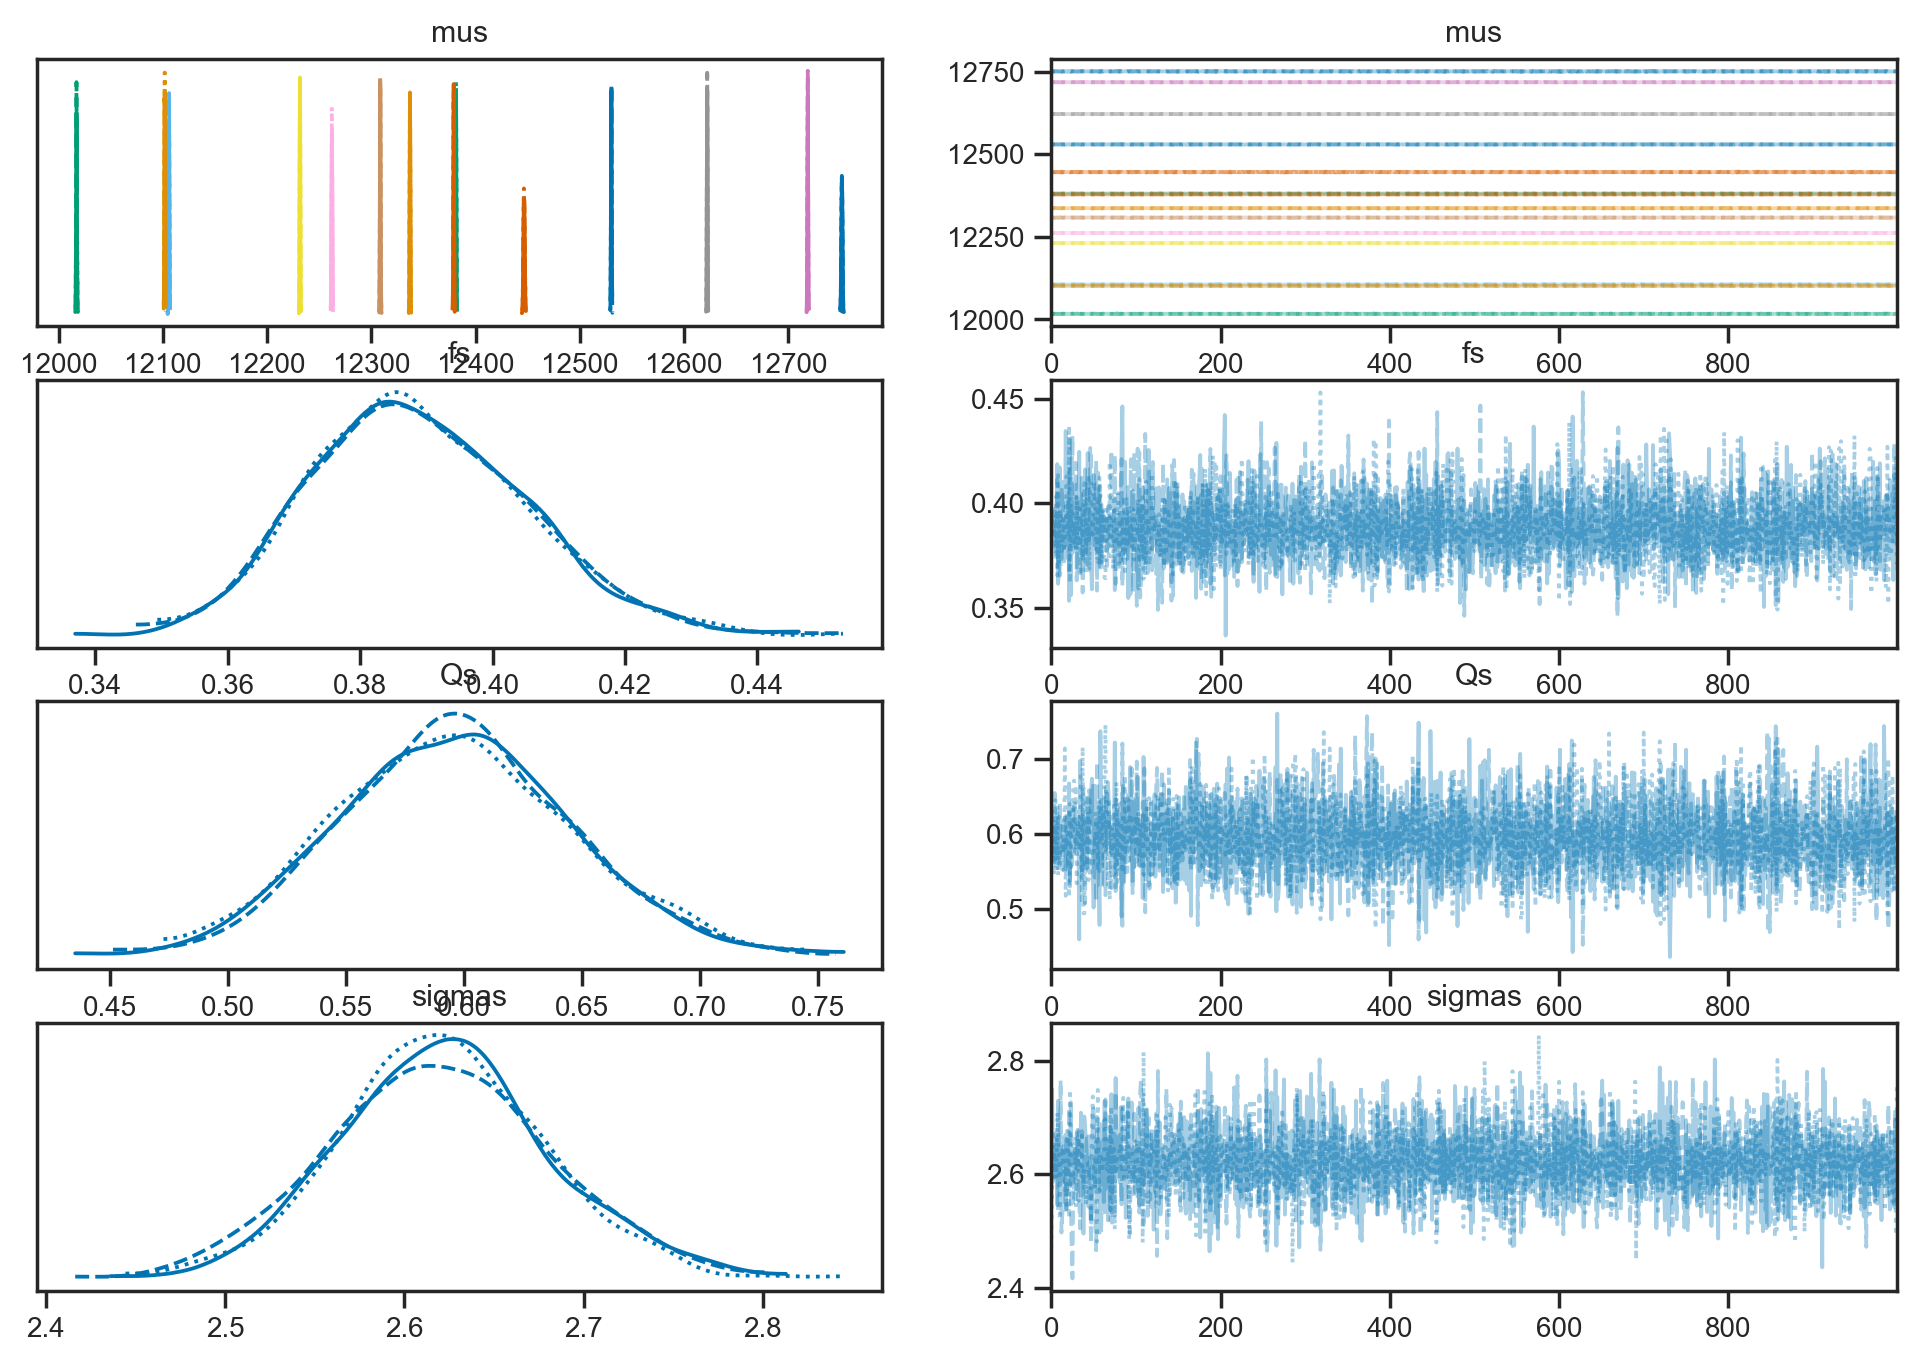

In [114]:
az.plot_trace(trace, var_names=['mus', 'fs', 'Qs', 'sigmas'])

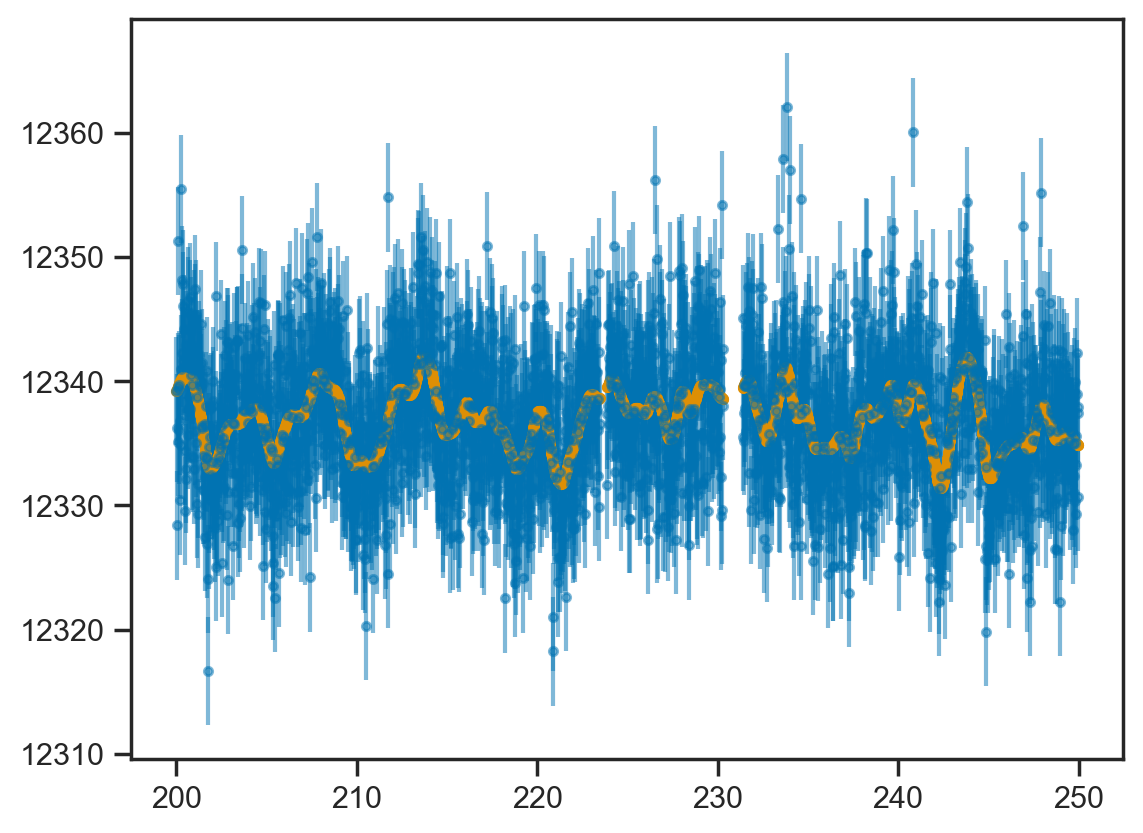

In [115]:
sel = np.abs(times[::thin_data]-225) < 25
plt.errorbar(times[::thin_data][sel], fluxes[::thin_data][sel], yerr=flux_errs[::thin_data][sel], fmt='.', alpha=0.5)
plt.plot(times[::thin_data][sel], trace.posterior['gp_mean_model'].mean(dim=('chain', 'draw')).values.flatten()[sel], '.')

The PSD peaks pretty close to the best-fit location from the literature:

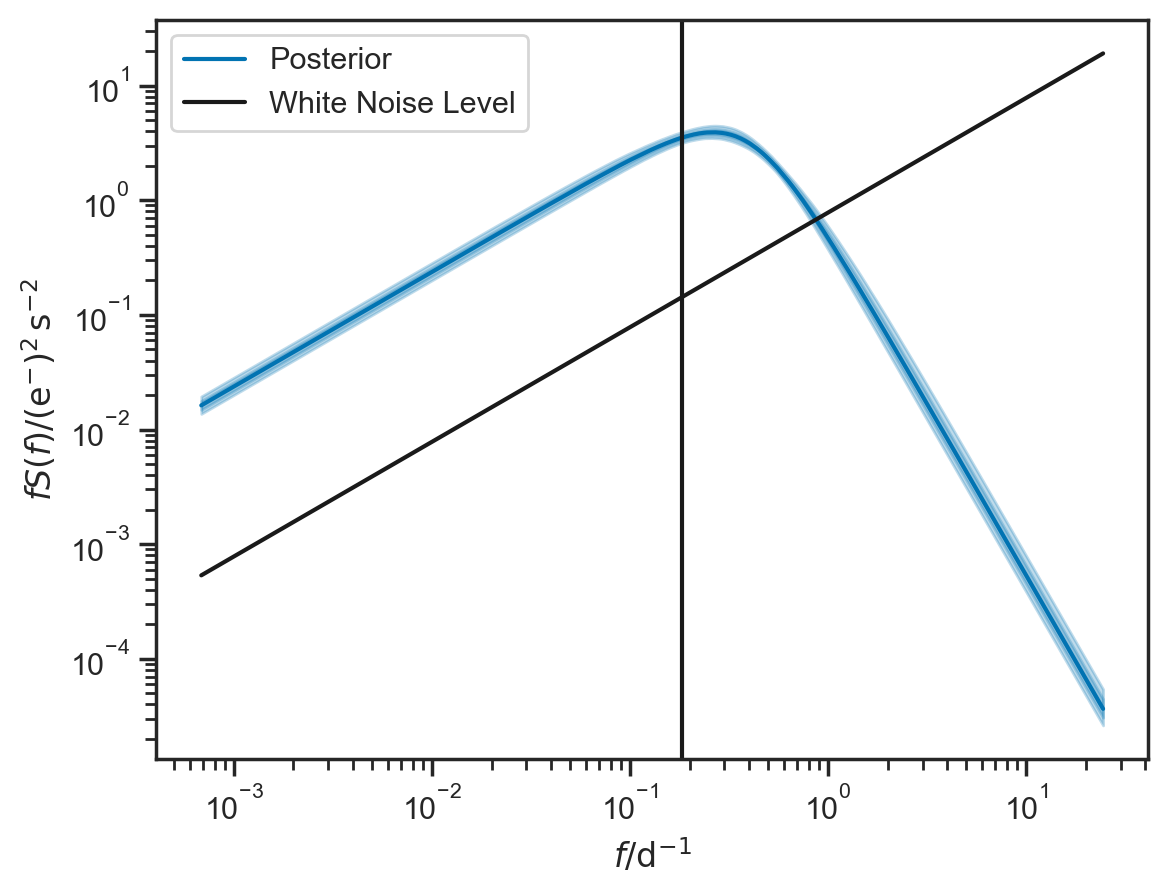

In [116]:
f = trace.posterior.frequencies.values.flatten()
l, = plt.loglog(f, f*trace.posterior.psd.median(dim=('chain', 'draw')).values.flatten(), label='Posterior')
plt.fill_between(f, f*trace.posterior.psd.quantile(0.84, dim=('chain', 'draw')).values.flatten(), f*trace.posterior.psd.quantile(0.16, dim=('chain', 'draw')).values.flatten(), alpha=0.25, color=l.get_color())
plt.fill_between(f, f*trace.posterior.psd.quantile(0.975, dim=('chain', 'draw')).values.flatten(), f*trace.posterior.psd.quantile(0.025, dim=('chain', 'draw')).values.flatten(), alpha=0.25, color=l.get_color())
plt.plot(f, f*(white_noise_variance/fny), 'k', label='White Noise Level')
plt.xlabel(r'$f / \mathrm{d}^{-1}$')
plt.ylabel(r'$f S(f) / \left( \mathrm{e}^{-} \right)^2 \, \mathrm{s}^{-2}$')
plt.legend()

plt.axvline(f_best_literature, color='k')

Because $Q$ is pretty small, the peak of the PSD and the `f` parameter are a bit different; but both are about twice the literature value for the peak frequency---maybe we are seeing some harmonics? ;)

Text(0.5, 0, '$f / \\mathrm{d}^{-1}$')

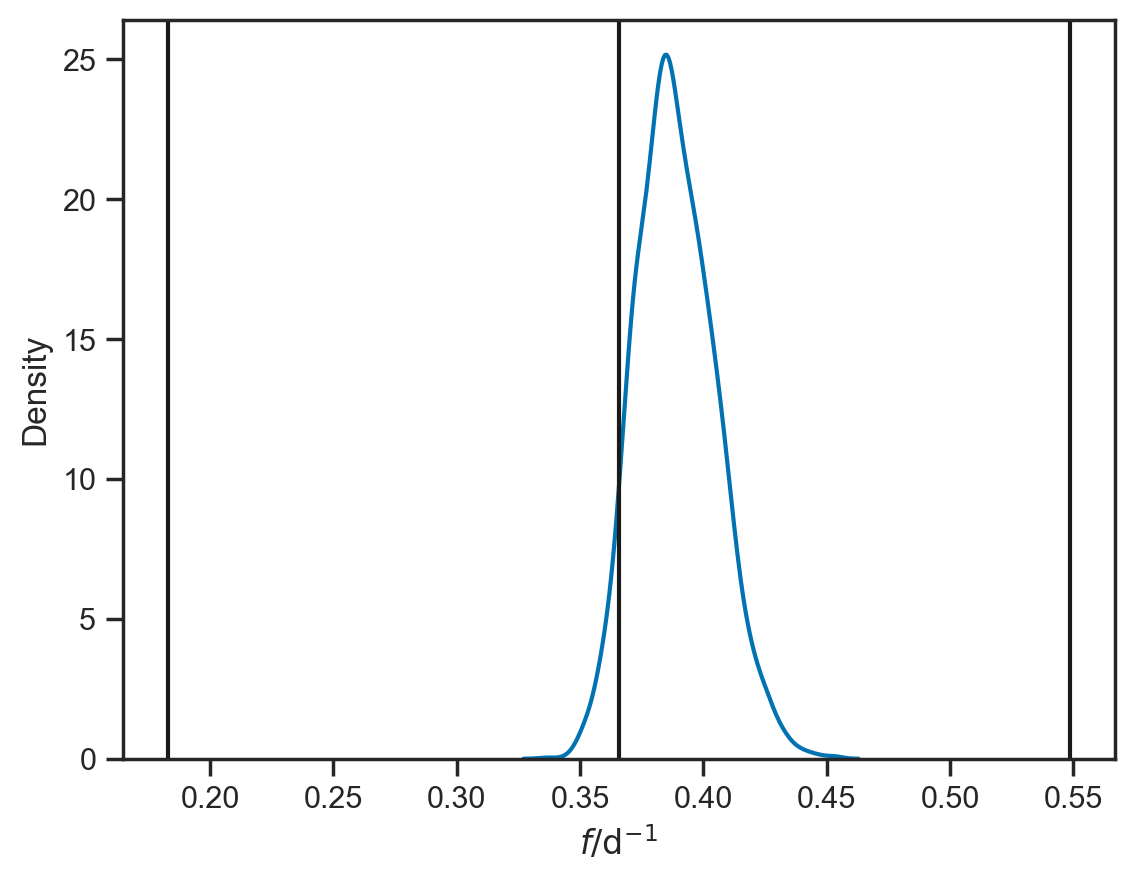

In [117]:
sns.kdeplot(trace.posterior['fs'].values.flatten())
plt.axvline(f_best_literature, color='k')
plt.axvline(2*f_best_literature, color='k')
plt.axvline(3*f_best_literature, color='k')
plt.xlabel(r'$f / \mathrm{d}^{-1}$')

Let's try fitting a two-mode model, at 1 and 2 times the best-fit frequency from the literature.  We will restrict the priors a bit more than above, since we are hunting for peaks at the literature frequencies.

In [118]:
harmonics = [1, 2]
thin_data = 1 # Set to large value to improve runtime at the cost of more uncertainty.
model2 = harmonic_sho_model(times[::thin_data], fluxes[::thin_data], flux_errs[::thin_data], quarters[::thin_data], f_best_literature, harmonics, quarter_means, quarter_stds, total_std, psd_freq=frequencies, predict_times=times[::thin_data], f_frac_uncert=0.1)

In [119]:
trace2 = pm.sample(tune=1000, draws=1000, cores=4, chains=4, model=model2, progressbar=True, jitter_max_retries=100, init='adapt_full')

Initializing NUTS using adapt_full...
/Users/wfarr/miniconda3/envs/harmonic-lomb-scargle/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:760: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mus_scaled, log_fs_scaled, log_Qs_scaled, log_sigma_scaled]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 346 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [121]:
trace2.sample_stats.lp.mean(dim='draw')

<xarray.DataArray 'lp' (chain: 4)> Size: 32B
array([-155787.81144877, -155788.23031233, -155787.63732358,
       -155788.05873044])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3

Those all look close enough in likelihood, let's proceed.

array([[<Axes: title={'center': 'mus'}>, <Axes: title={'center': 'mus'}>],
       [<Axes: title={'center': 'fs'}>, <Axes: title={'center': 'fs'}>],
       [<Axes: title={'center': 'Qs'}>, <Axes: title={'center': 'Qs'}>],
       [<Axes: title={'center': 'sigmas'}>,
        <Axes: title={'center': 'sigmas'}>]], dtype=object)

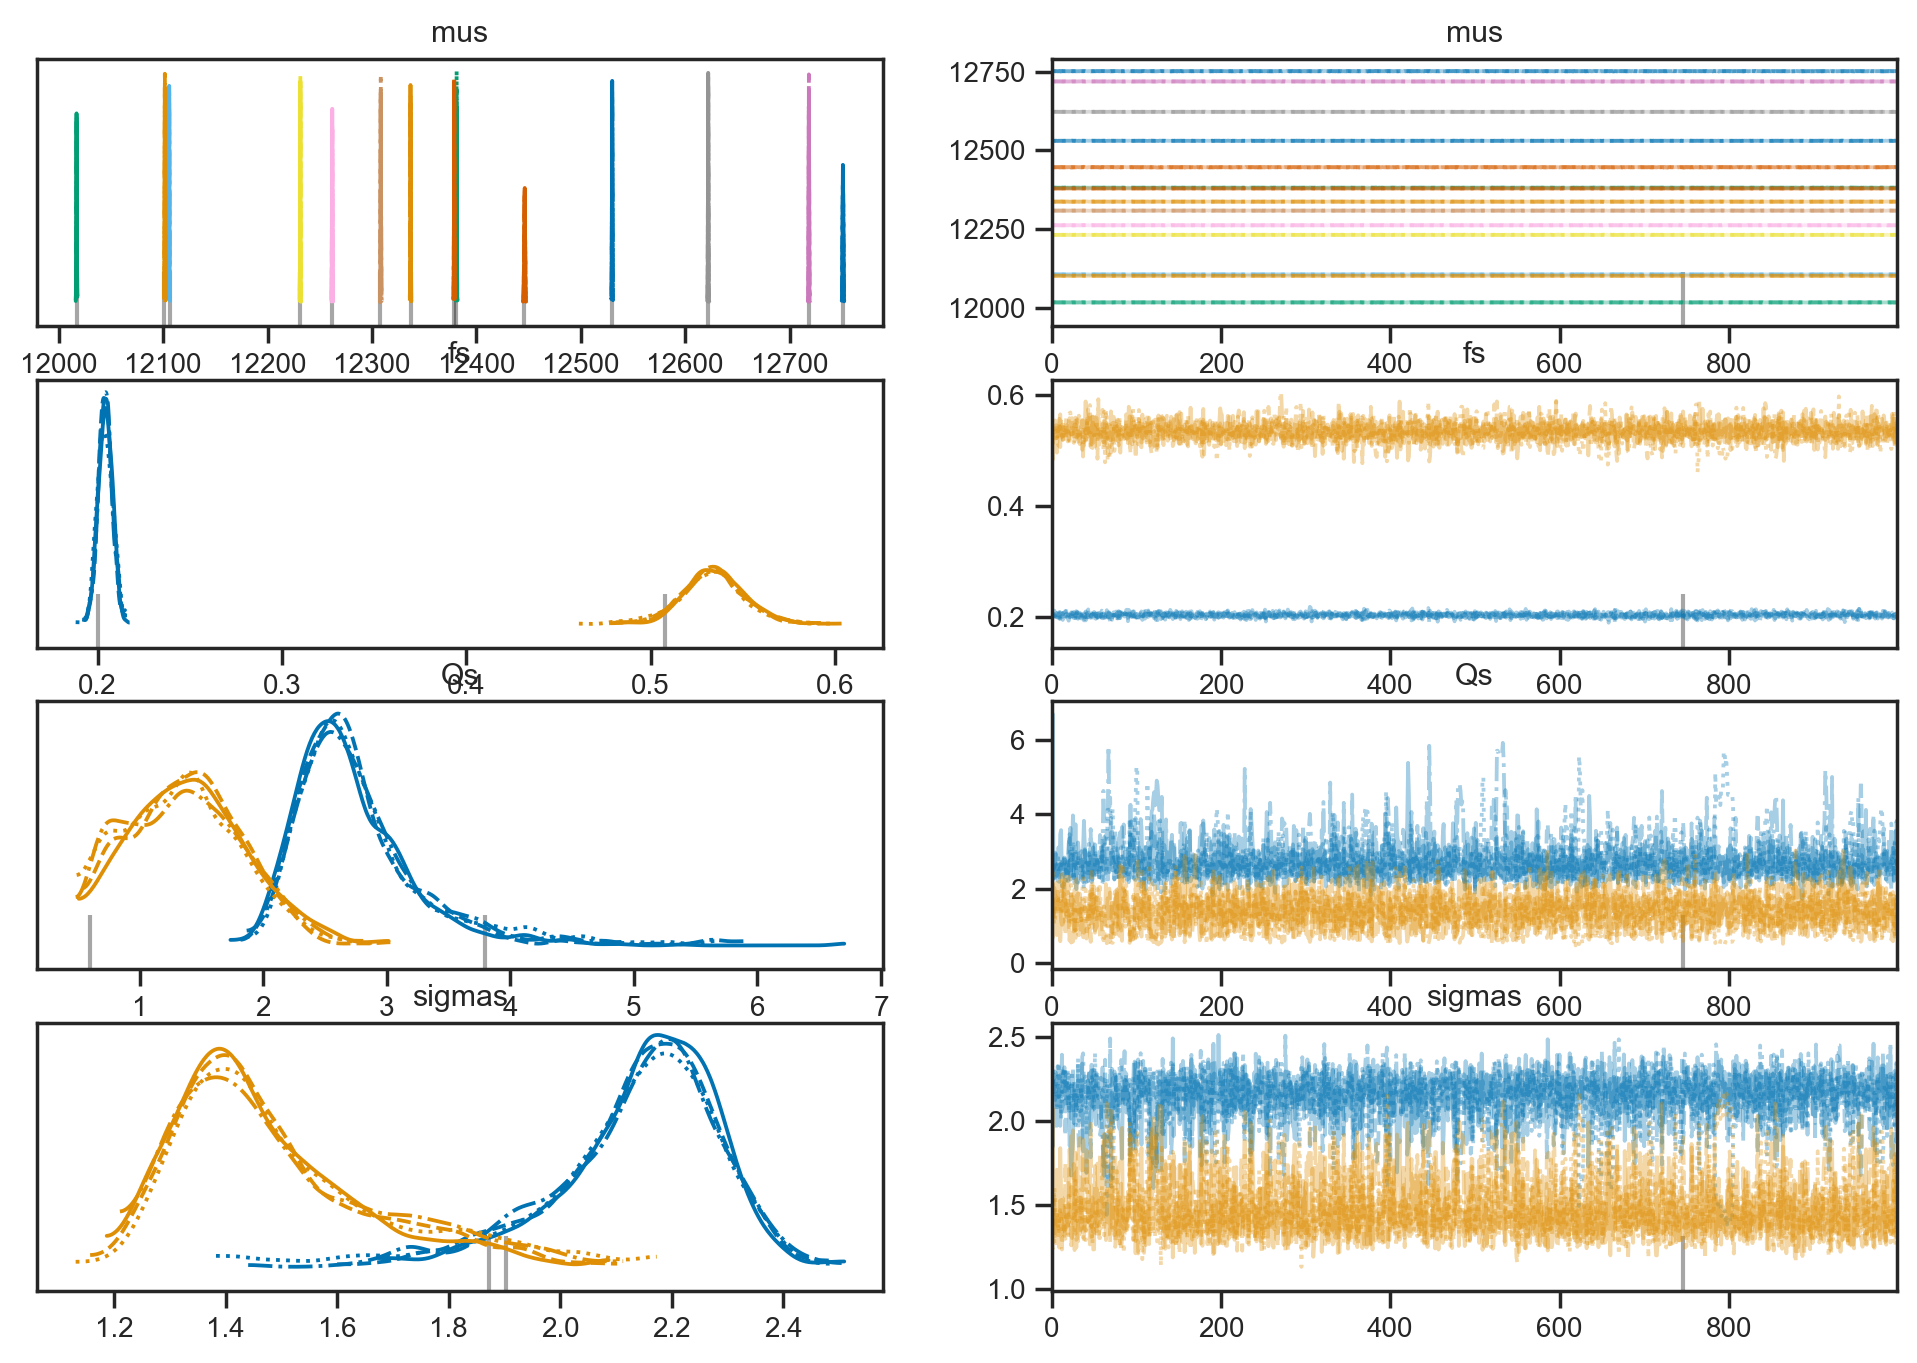

In [122]:
az.plot_trace(trace2, var_names=['mus', 'fs', 'Qs', 'sigmas'])

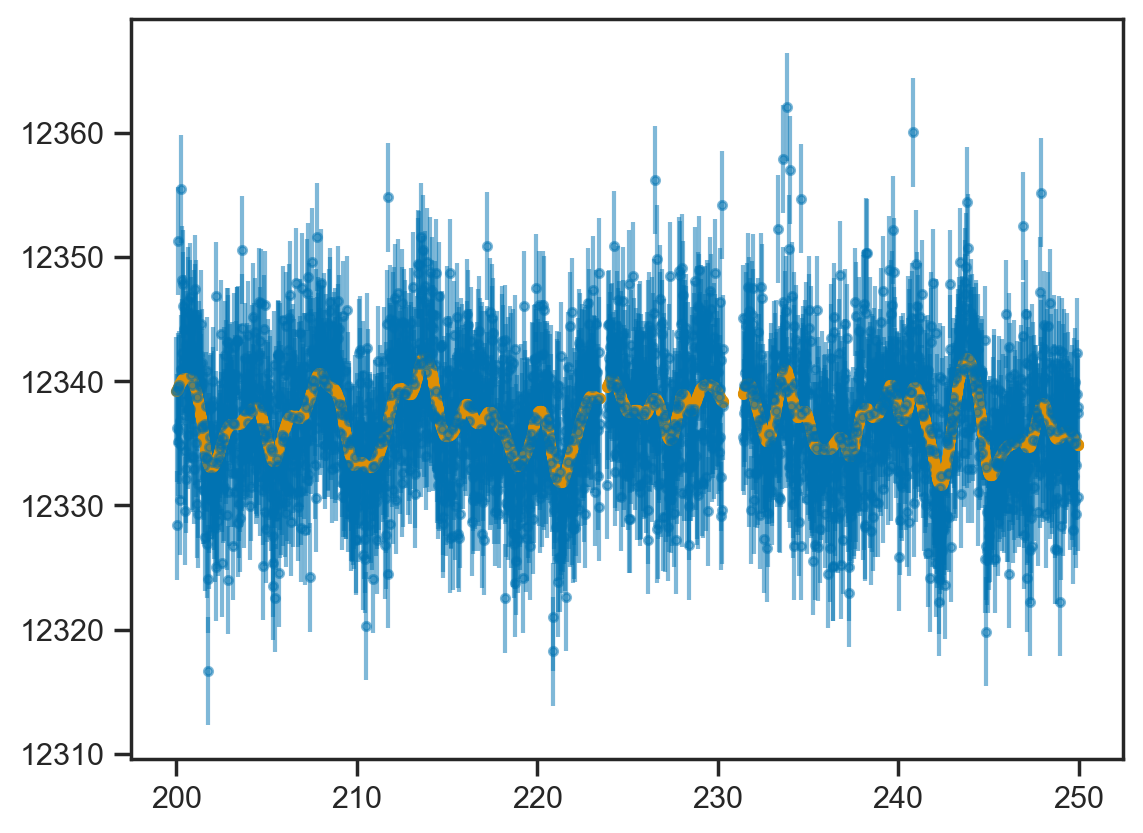

In [123]:
sel = np.abs(times[::thin_data]-225) < 25
plt.errorbar(times[::thin_data][sel], fluxes[::thin_data][sel], yerr=flux_errs[::thin_data][sel], fmt='.', alpha=0.5)
plt.plot(times[::thin_data][sel], trace2.posterior['gp_mean_model'].mean(dim=('chain', 'draw')).values.flatten()[sel], '.')

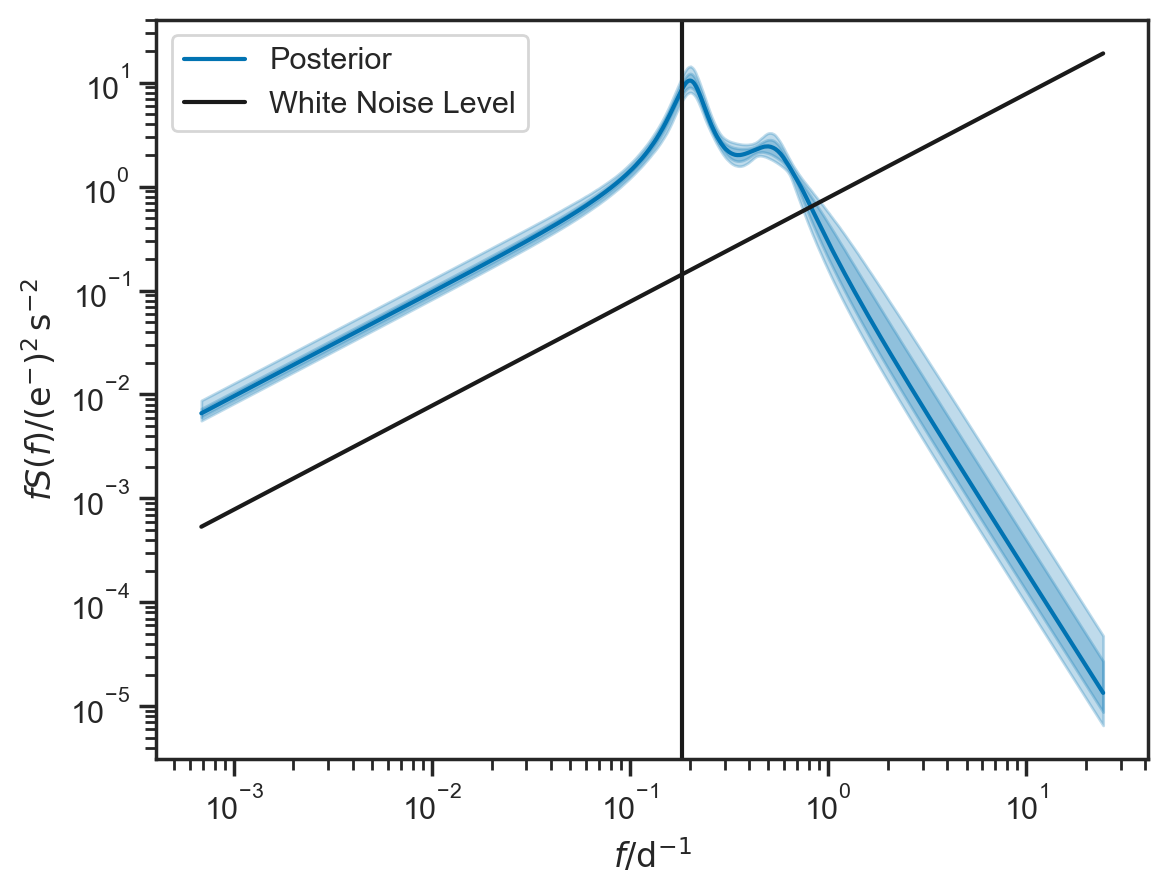

In [124]:
f = trace2.posterior.frequencies.values.flatten()
l, = plt.loglog(f, f*trace2.posterior.psd.median(dim=('chain', 'draw')).values.flatten(), label='Posterior')
plt.fill_between(f, f*trace2.posterior.psd.quantile(0.84, dim=('chain', 'draw')).values.flatten(), f*trace2.posterior.psd.quantile(0.16, dim=('chain', 'draw')).values.flatten(), alpha=0.25, color=l.get_color())
plt.fill_between(f, f*trace2.posterior.psd.quantile(0.975, dim=('chain', 'draw')).values.flatten(), f*trace2.posterior.psd.quantile(0.025, dim=('chain', 'draw')).values.flatten(), alpha=0.25, color=l.get_color())
plt.plot(f, f*(white_noise_variance/fny), 'k', label='White Noise Level')
plt.xlabel(r'$f / \mathrm{d}^{-1}$')
plt.ylabel(r'$f S(f) / \left( \mathrm{e}^{-} \right)^2 \, \mathrm{s}^{-2}$')
plt.legend()

plt.axvline(f_best_literature, color='k')

If we treat $f_1$ as the rotation period, we obtain 

Text(0.5, 1.0, '$P_\\mathrm{rot} = 4.898^{+0.092}_{-0.091} \\, \\mathrm{d}$')

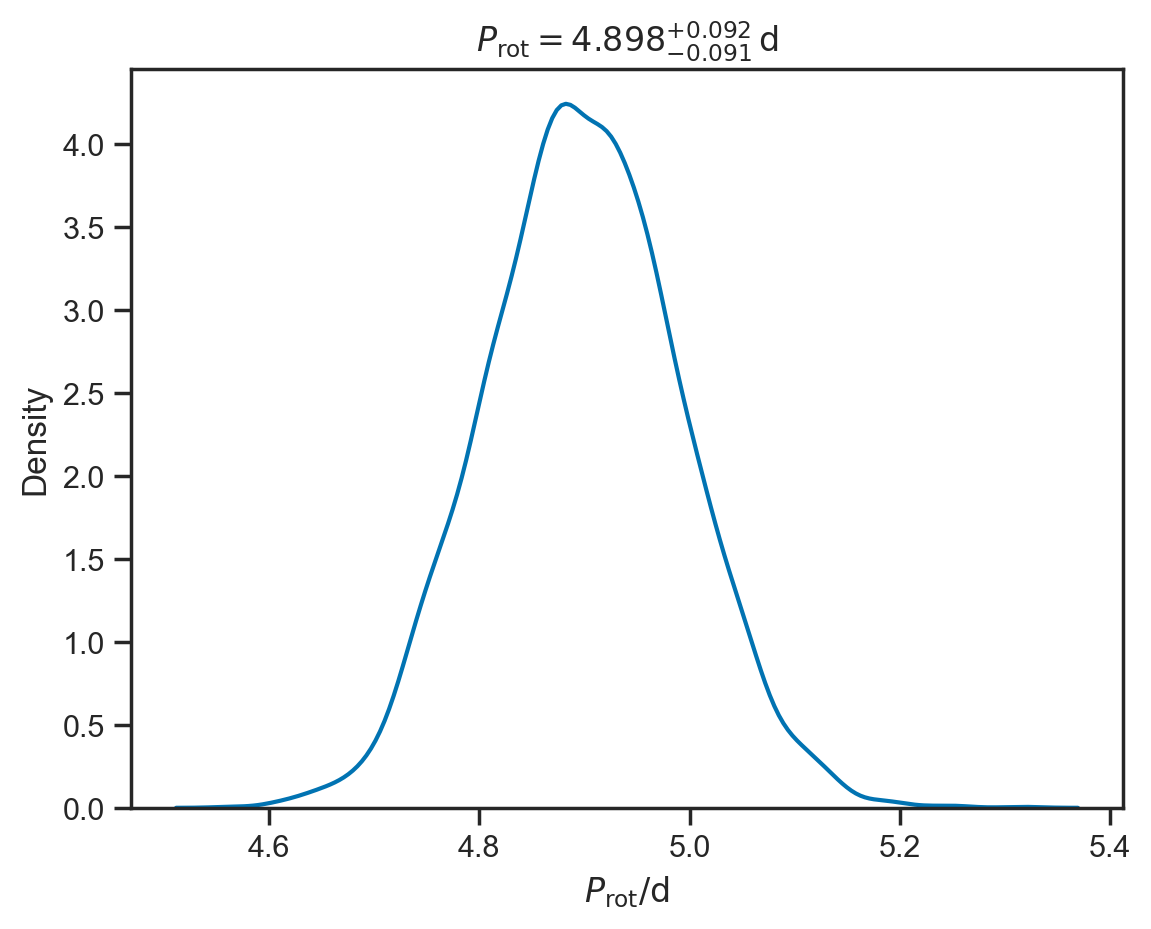

In [134]:
prot = 1/trace2.posterior.fs.sel(harmonics=1).values.flatten()
sns.kdeplot(prot)
plt.xlabel(r'$P_\mathrm{rot} / \mathrm{d}$')
m = np.median(prot)
h = np.quantile(prot, 0.84)
l = np.quantile(prot, 0.16)
plt.title(f'$P_\\mathrm{{rot}} = {m:.3f}^{{+{(h-m):.3f}}}_{{-{(m-l):.3f}}} \, \mathrm{{d}}$')

Text(0.5, 0, '$f_2 / f_1$')

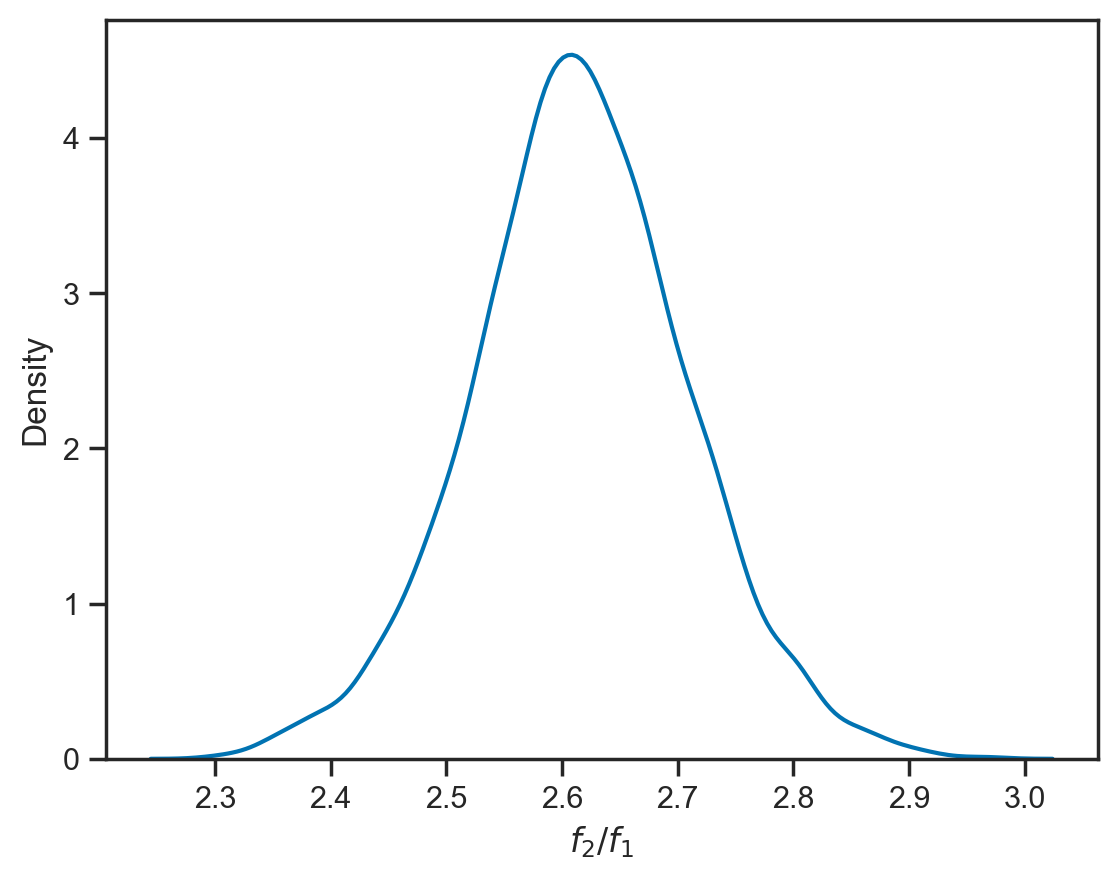

In [127]:
sns.kdeplot(trace2.posterior.fs.sel(harmonics=2).values.flatten()/trace2.posterior.fs.sel(harmonics=1).values.flatten())
plt.xlabel(r'$f_2 / f_1$')

The two frequencies that it finds are not really in a 2:1 ratio; it looks like the second harmonic is trying (but maybe constrained by the prior?) to be closer to 3:1, so let's try that model?

In [128]:
harmonics = [1, 3] 
thin_data = 1 # Set to large value to improve runtime at the cost of more uncertainty.
model3 = harmonic_sho_model(times[::thin_data], fluxes[::thin_data], flux_errs[::thin_data], quarters[::thin_data], f_best_literature, harmonics, quarter_means, quarter_stds, total_std, psd_freq=frequencies, predict_times=times[::thin_data], f_frac_uncert=0.1)

In [129]:
trace3 = pm.sample(tune=1000, draws=1000, cores=4, chains=4, model=model3, progressbar=True, jitter_max_retries=100, init='adapt_full')

Initializing NUTS using adapt_full...
/Users/wfarr/miniconda3/envs/harmonic-lomb-scargle/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:760: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mus_scaled, log_fs_scaled, log_Qs_scaled, log_sigma_scaled]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 432 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [130]:
trace3.sample_stats.lp.mean(dim='draw')

<xarray.DataArray 'lp' (chain: 4)> Size: 32B
array([-155780.46375633, -155780.16253353, -155780.04510836,
       -155780.39130663])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3

array([[<Axes: title={'center': 'mus'}>, <Axes: title={'center': 'mus'}>],
       [<Axes: title={'center': 'fs'}>, <Axes: title={'center': 'fs'}>],
       [<Axes: title={'center': 'Qs'}>, <Axes: title={'center': 'Qs'}>],
       [<Axes: title={'center': 'sigmas'}>,
        <Axes: title={'center': 'sigmas'}>]], dtype=object)

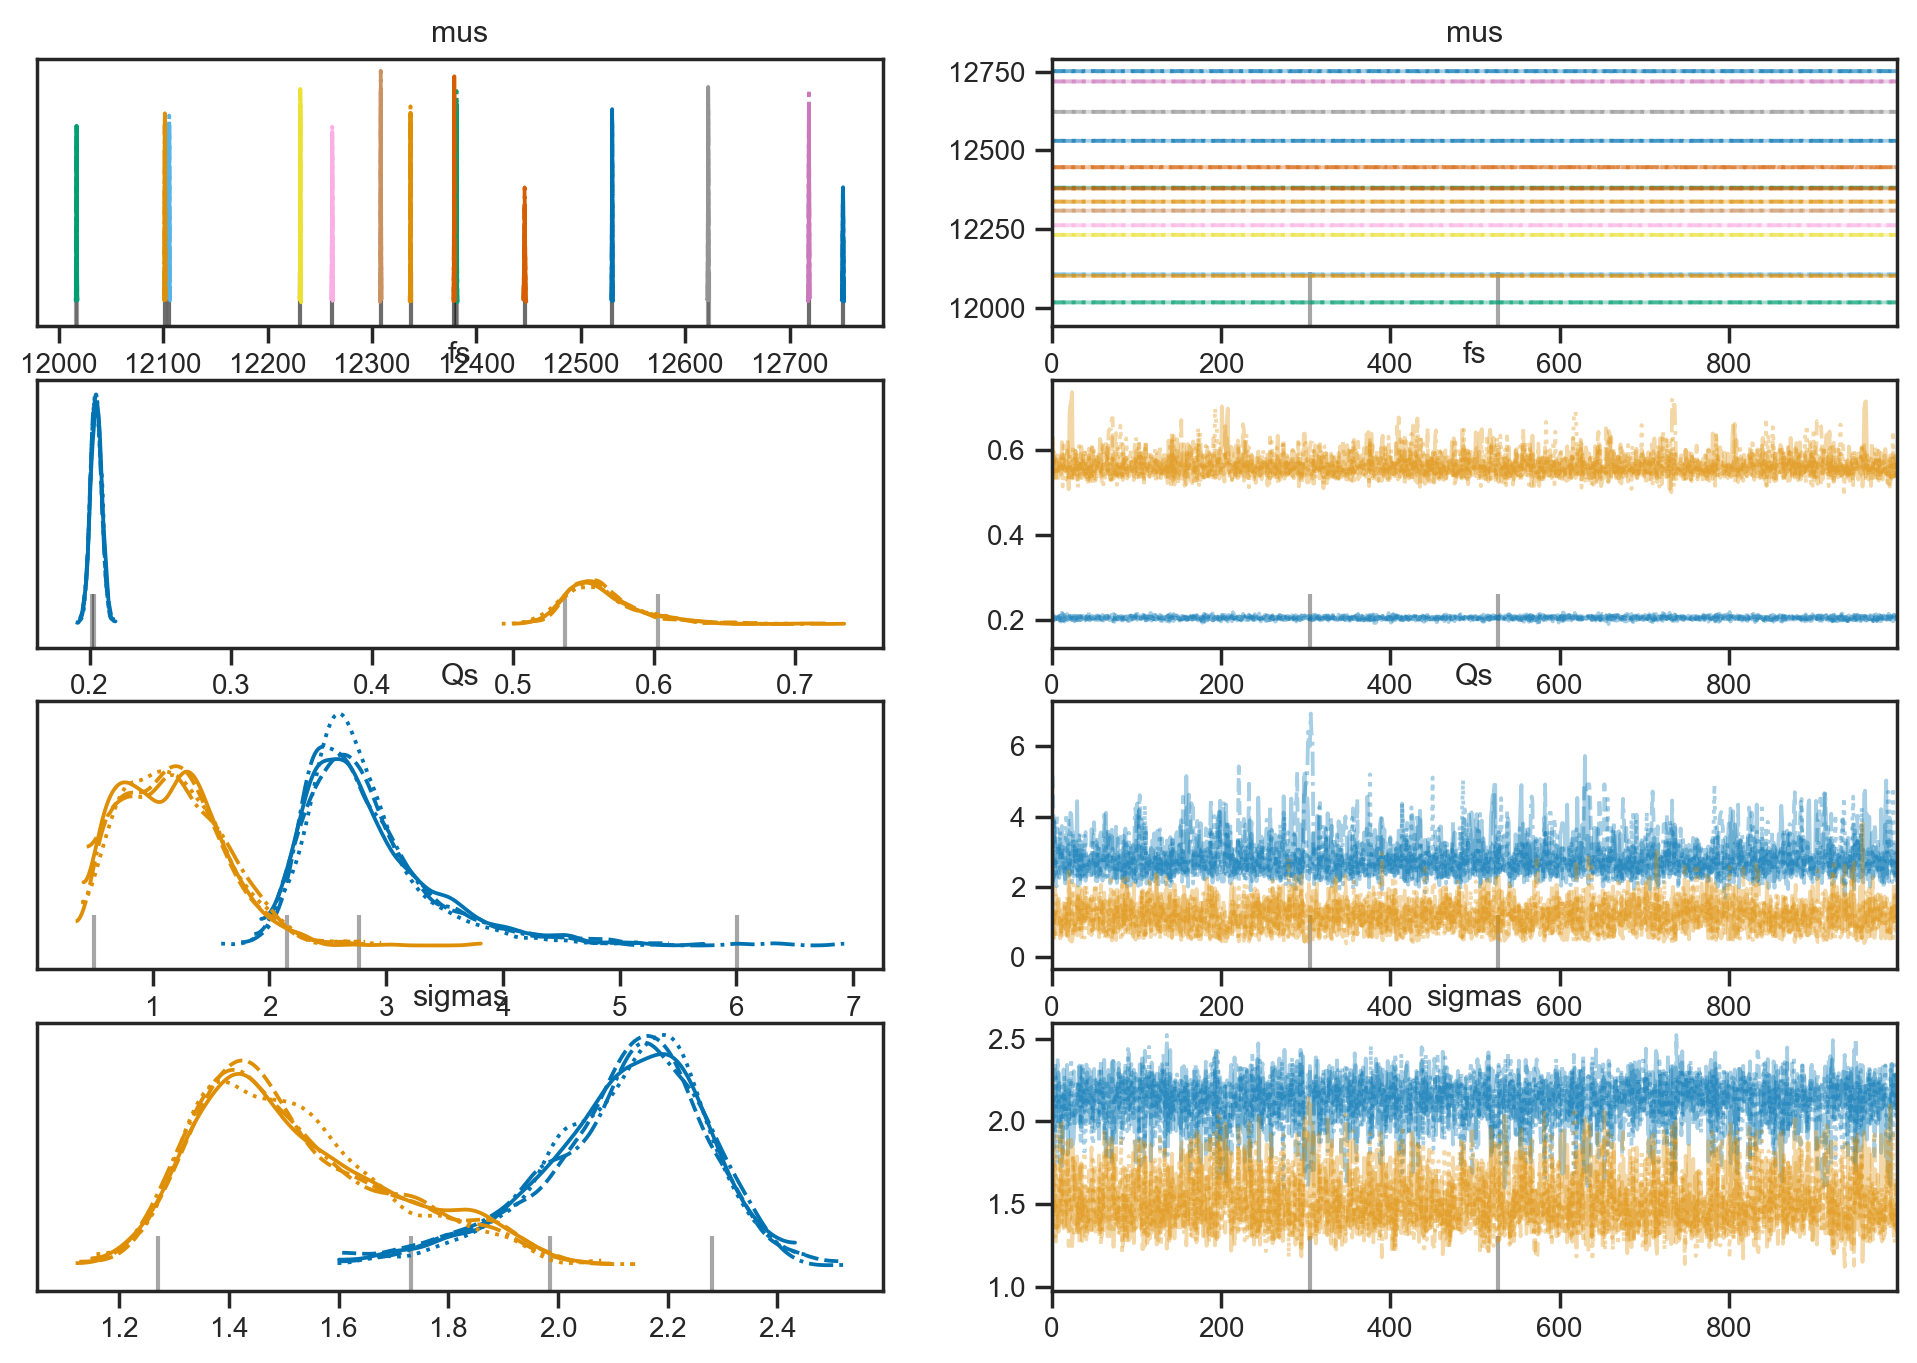

In [131]:
az.plot_trace(trace3, var_names=['mus', 'fs', 'Qs', 'sigmas'])

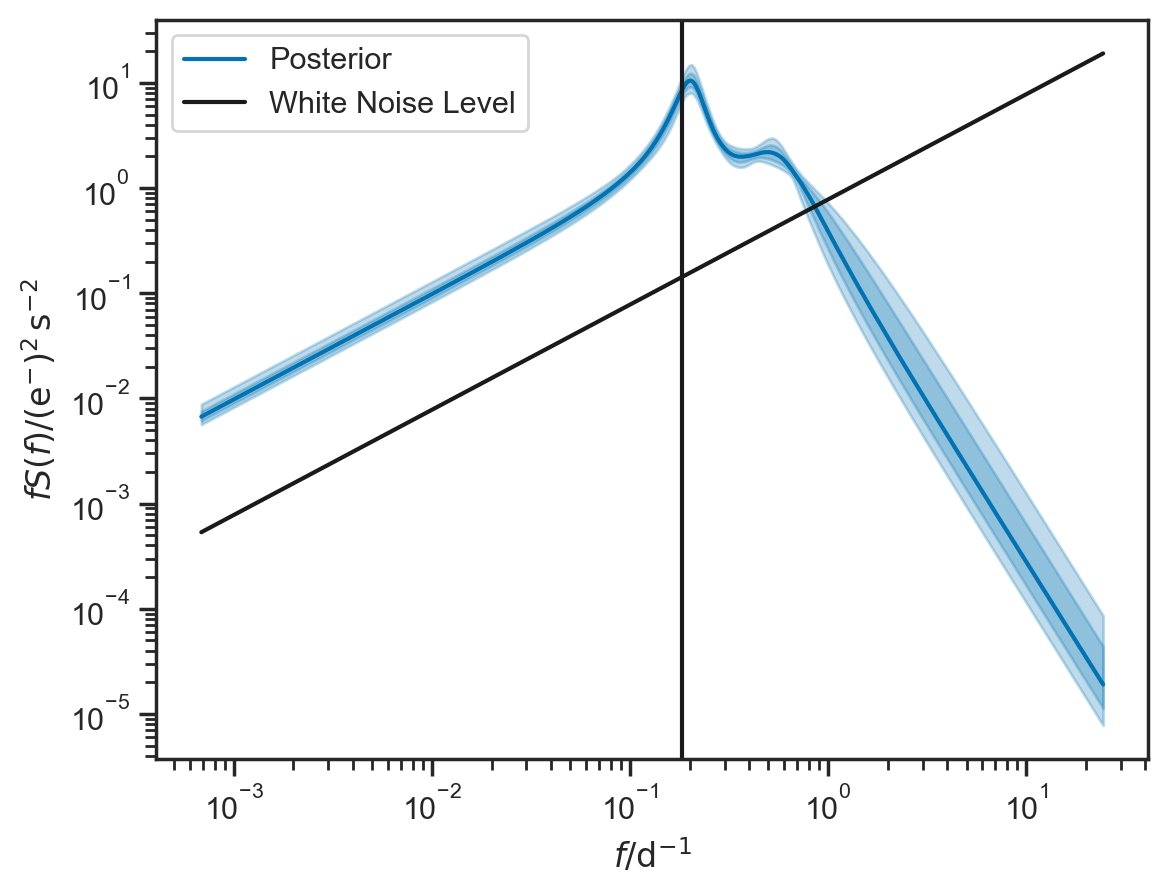

In [132]:
tp = trace3.posterior
f = tp.frequencies.values.flatten()
l, = plt.loglog(f, f*tp.psd.median(dim=('chain', 'draw')).values.flatten(), label='Posterior')
plt.fill_between(f, f*tp.psd.quantile(0.84, dim=('chain', 'draw')).values.flatten(), f*tp.psd.quantile(0.16, dim=('chain', 'draw')).values.flatten(), alpha=0.25, color=l.get_color())
plt.fill_between(f, f*tp.psd.quantile(0.975, dim=('chain', 'draw')).values.flatten(), f*tp.psd.quantile(0.025, dim=('chain', 'draw')).values.flatten(), alpha=0.25, color=l.get_color())
plt.plot(f, f*(white_noise_variance/fny), 'k', label='White Noise Level')
plt.xlabel(r'$f / \mathrm{d}^{-1}$')
plt.ylabel(r'$f S(f) / \left( \mathrm{e}^{-} \right)^2 \, \mathrm{s}^{-2}$')
plt.legend()

plt.axvline(f_best_literature, color='k')

If we treat $f_1$ as the rotation period, we obtain 

Text(0.5, 1.0, '$P_\\mathrm{rot} = 4.898^{+0.092}_{-0.091} \\, \\mathrm{d}$')

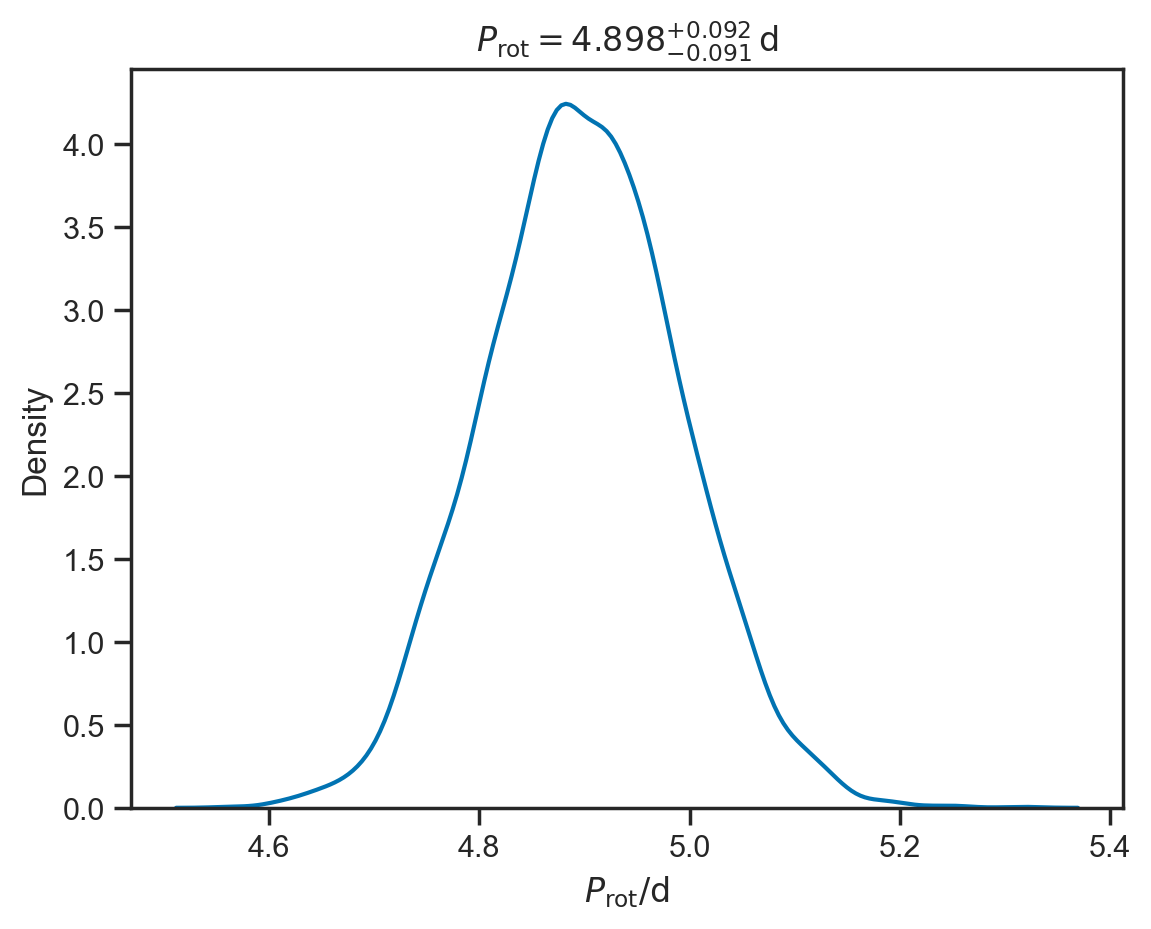

In [135]:
prot = 1/trace2.posterior.fs.sel(harmonics=1).values.flatten()
sns.kdeplot(prot)
plt.xlabel(r'$P_\mathrm{rot} / \mathrm{d}$')
m = np.median(prot)
h = np.quantile(prot, 0.84)
l = np.quantile(prot, 0.16)
plt.title(f'$P_\\mathrm{{rot}} = {m:.3f}^{{+{(h-m):.3f}}}_{{-{(m-l):.3f}}} \, \mathrm{{d}}$')

Text(0.5, 0, '$f_3 / f_1$')

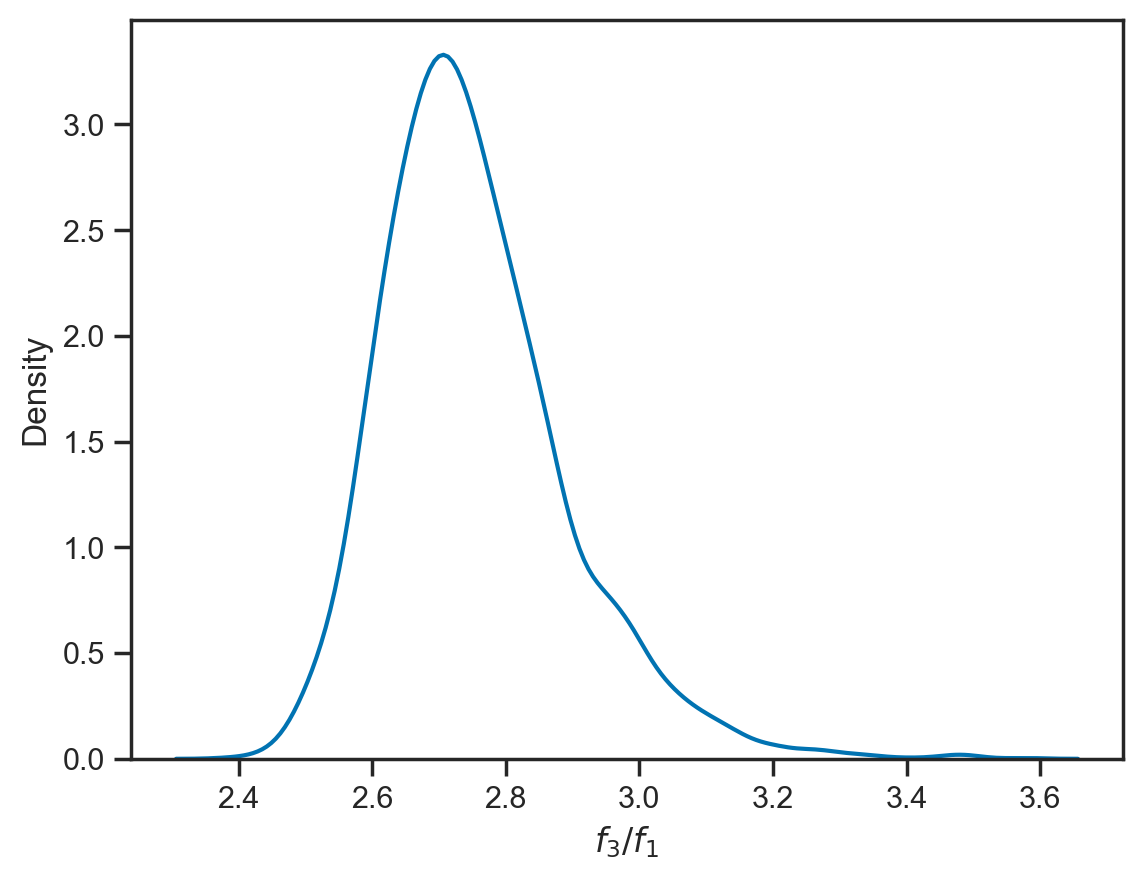

In [136]:
sns.kdeplot(trace3.posterior.fs.sel(harmonics=3).values.flatten()/trace3.posterior.fs.sel(harmonics=1).values.flatten())
plt.xlabel(r'$f_3 / f_1$')

These are much closer to being in a 3:1 ratio, so maybe we are actually getting something reasonable (though they aren't perfectly in 3:1)!

Can we find a third harmonic?  (Evidently the answer is no---I cannot get a three-harmonic model to fit.)

In [66]:
harmonics = [1, 3] 
thin_data = 1 # Set to large value to improve runtime at the cost of more uncertainty.
model3 = harmonic_sho_model(times[::thin_data], fluxes[::thin_data], flux_errs[::thin_data], quarters[::thin_data], f_best_literature, harmonics, quarter_means, quarter_stds, total_std, psd_freq=frequencies, predict_times=times[::thin_data], f_frac_uncert=0.1)

In [67]:
trace3 = pm.sample(tune=1000, draws=1000, cores=4, chains=4, model=model3, progressbar=True, jitter_max_retries=100, init='adapt_full')

Initializing NUTS using adapt_full...
/Users/wfarr/miniconda3/envs/harmonic-lomb-scargle/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:760: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mus_scaled, log_fs_scaled, log_Qs_scaled, log_sigma_scaled]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 761 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [71]:
trace3.sample_stats.lp.mean(dim='draw')

<xarray.DataArray 'lp' (chain: 4)> Size: 32B
array([-161279.23551852, -162035.30692359, -162035.37499709,
       -162035.71414351])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3

In [73]:
az.plot_trace(trace3.sel(chain=0), var_names=['mus', 'fs', 'Qs', 'sigmas'])

TypeError: len() of unsized object

In [76]:
tp = trace3.posterior.sel(chain=[0])

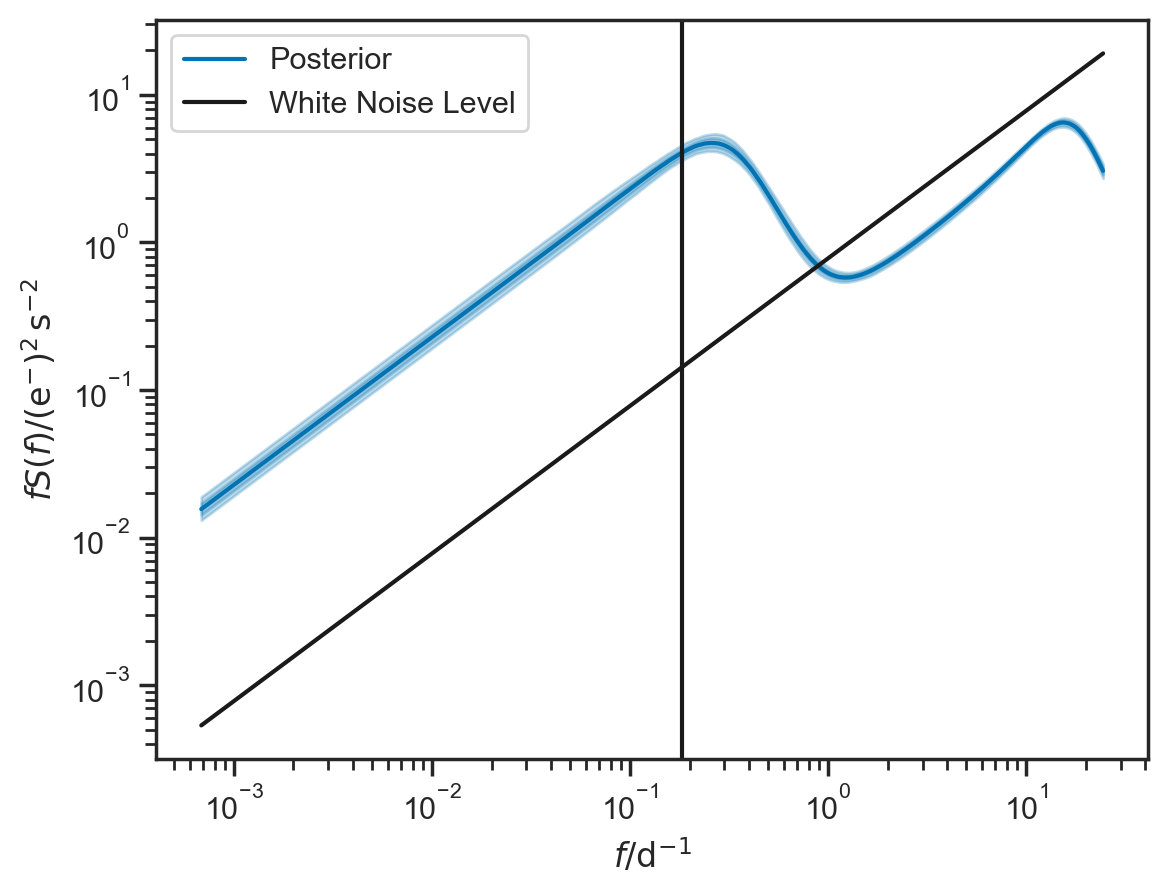

In [77]:
f = trace3.posterior.frequencies.values.flatten()
l, = plt.loglog(f, f*tp.psd.median(dim=('chain', 'draw')).values.flatten(), label='Posterior')
plt.fill_between(f, f*tp.psd.quantile(0.84, dim=('chain', 'draw')).values.flatten(), f*tp.psd.quantile(0.16, dim=('chain', 'draw')).values.flatten(), alpha=0.25, color=l.get_color())
plt.fill_between(f, f*tp.psd.quantile(0.975, dim=('chain', 'draw')).values.flatten(), f*tp.psd.quantile(0.025, dim=('chain', 'draw')).values.flatten(), alpha=0.25, color=l.get_color())
plt.plot(f, f*(white_noise_variance/fny), 'k', label='White Noise Level')
plt.xlabel(r'$f / \mathrm{d}^{-1}$')
plt.ylabel(r'$f S(f) / \left( \mathrm{e}^{-} \right)^2 \, \mathrm{s}^{-2}$')
plt.legend()

plt.axvline(f_best_literature, color='k')

If we treat $f_1$ as the rotation period, we obtain 

Text(0.5, 1.0, '$P_\\mathrm{rot} = 4.84^{+0.09}_{-0.09} \\, \\mathrm{d}$')

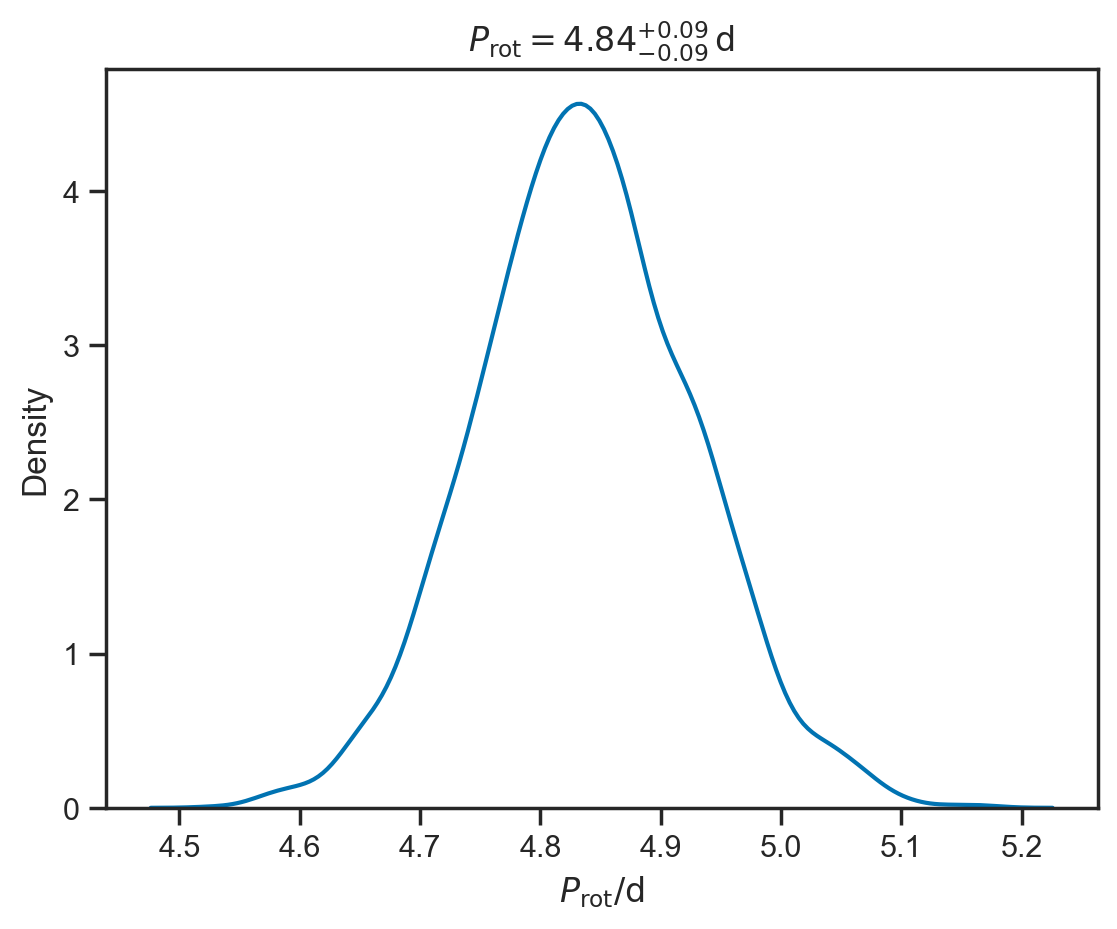

In [ ]:
prot = 1/trace2.posterior.fs.sel(harmonics=1).values.flatten()
sns.kdeplot(prot)
plt.xlabel(r'$P_\mathrm{rot} / \mathrm{d}$')
m = np.median(prot)
h = np.quantile(prot, 0.84)
l = np.quantile(prot, 0.16)
plt.title(f'$P_\\mathrm{{rot}} = {m:.2f}^{{+{(h-m):.2f}}}_{{-{(m-l):.2f}}} \, \mathrm{{d}}$')